# Interpretability of the utilitarianism task from the ethics dataset

Paper in which the dataset was released: https://arxiv.org/abs/2008.02275 (ICLR, Hendrycks et al., 2021)

The transformer model used in this in depth exploration is the RoBERTa-large model whose weights were released alongside the original paper here: https://github.com/hendrycks/ethics

The utilitarianism task dataset consisted of a training dataset, an easy test dataset, and a hard test dataset.

In [23]:
SAVE_FIGS = True # If true, Figures will be saved (overwriting previous versions) as cells are run
DIR = "figure_outputs/"

# Setup

In [2]:
# Packages

!git clone https://github.com/hendrycks/ethics.git 

!pip install torch transformers pytorch-transformers # ML
!pip install seaborn pandas matplotlib # Data
!pip install bertviz captum shap # Interpretability

Cloning into 'ethics'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 82 (delta 31), reused 19 (delta 6), pack-reused 0
Unpacking objects: 100% (82/82), done.
     |████████████████████████████████| 2.1MB 17.9MB/s 
     |████████████████████████████████| 184kB 53.5MB/s 
     |████████████████████████████████| 901kB 54.0MB/s 
     |████████████████████████████████| 3.3MB 50.9MB/s 
     |████████████████████████████████| 133kB 54.4MB/s 
     |████████████████████████████████| 1.2MB 48.6MB/s 
     |████████████████████████████████| 81kB 10.2MB/s 
     |████████████████████████████████| 7.4MB 48.7MB/s 
ERROR: botocore 1.20.56 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.
     |████████████████████████████████| 163kB 22.2MB/s 
     |████████████████████████████████| 4.4MB 24.1MB/s 
     |████████████████████████████████| 358kB 50.2MB/s 
  Crea

In [3]:
# Mount Google Drive

from google.colab import drive
import sys

drive.mount(f'/content/drive')

%cd /content/drive/MyDrive/Colab Notebooks/NLP_CW2
sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks/NLP_CW2')

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1g3JCgH-awK6a0hTXlBoIT3NgyxvgLv_M/NLP_CW2


In [42]:
# Imports

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer

In [43]:
# Model loading functions

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Args:
  def __init__(self, model, ngpus=2, max_length=64):
    self.model = model
    self.ngpus = ngpus
    self.max_length = max_length

def load_model(model, ngpus, load_path):
    config = AutoConfig.from_pretrained(model, num_labels=1, output_attentions=True, output_pretrained=True)
    model = AutoModelForSequenceClassification.from_pretrained(model, config=config)

    # Use strict=False since the provided models were originally trained with an earlier version of Huggingface
    model.load_state_dict(torch.load(load_path), strict=False)  
    if args.ngpus > 0:
        model = model.cuda()
        model = torch.nn.DataParallel(model, device_ids=[i for i in range(ngpus)])
    return model

# Visualizing attention

## BertViz

TODO broad explanation

In [6]:
# Load model

args = Args(model='roberta-large', ngpus=1)
load_path = 'util_roberta-large.pt'

model = load_model(args.model, args.ngpus, load_path)
model.eval()

tokenizer = AutoTokenizer.from_pretrained(args.model)

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classif

In [7]:
# Example

sentence_a = "As I prepared for my annual Christmas party, I looked forward to showing off my decorations and food."
sentence_b = "As I prepared for my annual Christmas party, I didn't look forward to having my decorations and food judged."

### Head view

TODO explanation

In [20]:
from bertviz import head_view

inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True)
input_ids = inputs['input_ids']
attention = model(input_ids)[-1]
input_id_list = input_ids[0].tolist() 
tokens = tokenizer.convert_ids_to_tokens(input_id_list)
head_view(attention, tokens)

### Model view

TODO explanation

In [9]:
from bertviz import model_view

inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True)
input_ids = inputs['input_ids']
attention = model(input_ids)[-1]
input_id_list = input_ids[0].tolist()
tokens = tokenizer.convert_ids_to_tokens(input_id_list)
model_view(attention, tokens)

### Neuron view

TODO explanation if possible

In [ ]:
# from bertviz import neuron_view
# from bertviz.neuron_view import show
# from bertviz.transformers_neuron_view import RobertaModel, RobertaTokenizer

# model = RobertaModel.from_pretrained(args.model)
# tokenizer = RobertaTokenizer.from_pretrained(args.model)

# show(model, 'roberta', tokenizer, sentence_a, sentence_b)

# Shapley-value explanations

## SHAP

TODO broad explanation

In [17]:
# Imports

from ethics.utils import get_ids_mask, load_util_sentences
import shap

In [ ]:
# Load model

args = Args(model='roberta-large', ngpus=1)
load_path = 'util_roberta-large.pt'

model = load_model(args.model, args.ngpus, load_path)
model.eval()

tokenizer = AutoTokenizer.from_pretrained(args.model)

In [67]:
# Load sentences

data_dir = '/content/drive/MyDrive/Colab Notebooks/NLP_CW2/utilitarianism/'

sentences, labels = load_util_sentences(data_dir, split='test')
sentences = ["[CLS] " + s for s in sentences]

In [102]:
# Define utility function to visualize

def predict_utility(sentence):
  ids, amasks = get_ids_mask(sentence, tokenizer, args.max_length)
  inputs, masks = torch.tensor(ids), torch.tensor(amasks)

  output = model(inputs)[0]
  output = output[:, 0]

  return output.detach().cpu().numpy()

### Plots

In [ ]:
# Examples to visualize

examples = sentences[100:110]

for example in examples:
  print(example)

In [ ]:
# Compute Shapley values

explainer = shap.Explainer(predict_utility, tokenizer)
shap_values = explainer(examples)

#### Text plot

In [112]:
shap.plots.text(shap_values[8])

#### Waterfall plot

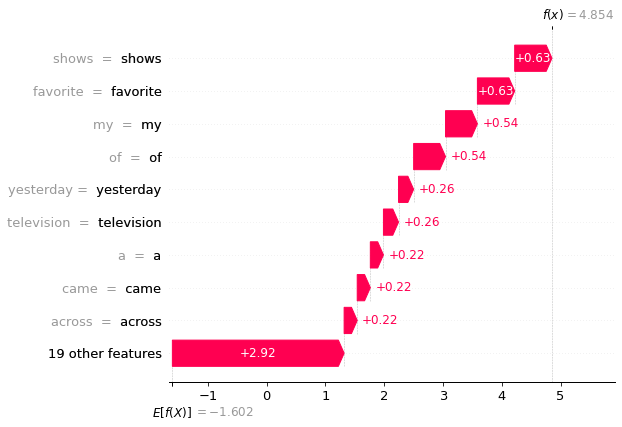

<Figure size 432x288 with 0 Axes>

In [91]:
shap.plots.waterfall(shap_values[8])

if SAVE_FIGS==True:
  figure = plt.gcf()
  figure.savefig(f"interpretability-shap-plots-waterfall", dpi=300)

#### Force plot

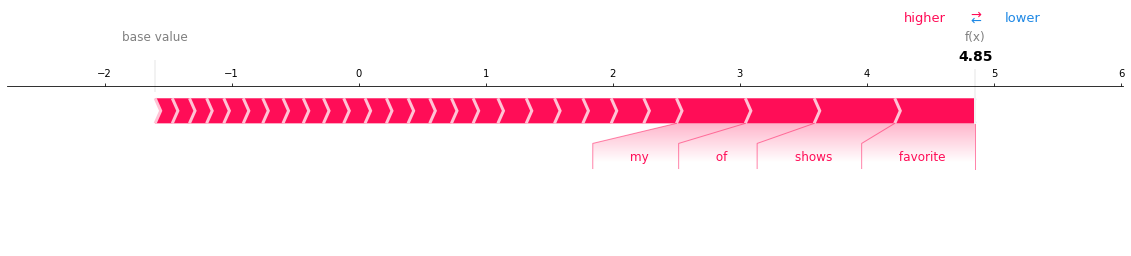

<Figure size 432x288 with 0 Axes>

In [98]:
shap.plots.force(shap_values[8], matplotlib=True)

if SAVE_FIGS==True:
  figure = plt.gcf()
  figure.savefig(f"interpretability-shap-plots-force", dpi=300)

#### Bar plot

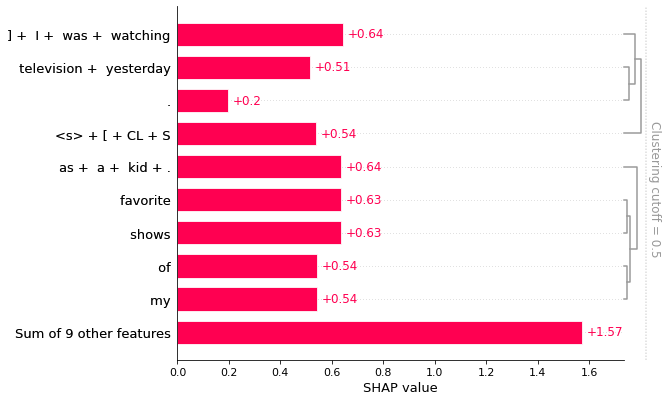

In [106]:
shap.plots.bar(shap_values[8])

if SAVE_FIGS==True:
  figure = plt.gcf()
  figure.savefig(f"interpretability-shap-plots-bar", dpi=300)

### Comparing utilities

In [115]:
# Examples to visualize and compare

sentence_a = "I went to the shop."
sentence_b = "I went to the shop and bought my friend a Birthday present."

examples = [sentence_a, sentence_b]

In [116]:
# Compute Shapley values

explainer = shap.Explainer(predict_utility, tokenizer)
shap_values = explainer(examples)

#### Text plot comparison

In [118]:
shap.plots.text(shap_values[0])

In [119]:
shap.plots.text(shap_values[1])

# Gradient-based explanations

## Captum

In [ ]:
# https://blog.fiddler.ai/2019/08/should-you-explain-your-predictions-with-shap-or-ig/
# https://captum.ai/docs/extension/integrated_gradients
# https://captum.ai/tutorials/IMDB_TorchText_Interpret

# https://github.com/ankurtaly/Integrated-Gradients

In [25]:
# Imports

from transformers import BertTokenizer, BertForQuestionAnswering, BertConfig

from captum.attr import visualization as viz
from captum.attr import IntegratedGradients, LayerConductance, LayerIntegratedGradients
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer

In [ ]:
# Load model

model = load_model(args.model, args.ngpus, load_path)
model.to(device)

model.eval()
model.zero_grad()

tokenizer = AutoTokenizer.from_pretrained(args.model)

In [45]:
lig = LayerIntegratedGradients(model)

TypeError: ignored